## 1. Setup

In [162]:
import os
import cv2
import numpy as np
import seaborn as sns
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from collections import defaultdict

## 2. Src

In [246]:
COCO_KEYPOINT_NAMES = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

In [247]:
def draw_keypoints(kps):
    min_vals = kps.min(axis=0)
    max_vals = kps.max(axis=0)
    length = max(max_vals - min_vals)
    
    for i, kp in enumerate(kps):
        x, y = kp[0], kp[1]
        y = max_vals[1] - y + min_vals[1]
        plt.scatter(x, y, c='r')
        plt.text(x, y, str(i), fontsize=12, color='black')
    
    plt.xlim(min_vals[0], min_vals[0] + length)
    plt.ylim(min_vals[1], min_vals[1] + length)


class Keypoints:    
    def __init__(self, keypoints):
        self.keypoints = keypoints # (17 x 3)
        self.names = COCO_KEYPOINT_NAMES.copy()
        
        self.generate_synthetic_keypoints()
        self.normalized_keypoints, self.center_of_mess, self.max_length = self.normalize()
    

    def generate_synthetic_keypoints(self):
        get_center = lambda key1, key2: (self.get(key1, normalized=False) + self.get(key2, normalized=False)) / 2
        
        synthetic_keypoints, synthetic_names = [], []
        for name in ['eye', 'ear', 'shoulder', 'elbow', 'wrist', 'hip', 'knee', 'ankle']:
            p = get_center(f'left_{name}', f'right_{name}')
            synthetic_keypoints.append(p)
            synthetic_names.append(name)
        
        self.keypoints = np.vstack([self.keypoints, np.array(synthetic_keypoints)])
        self.names += synthetic_names


    def normalize(self, threshold=0.5):
        keypoints = self.keypoints.copy()
        
        # translation
        is_valid = keypoints[:, 2] > threshold
        is_valid[1:5] = False # ignore face keypoints except nose
        is_valid[17:] = False # ignore synthetic keypoints
        is_valid[:] = True if is_valid.sum() < 5 else is_valid # if not enough keypoints, use all
        
        center_of_mass = keypoints[is_valid, :2].mean(axis=0, keepdims=True)
        keypoints[:, :2] -= center_of_mass

        # scaling
        max_length = np.linalg.norm(keypoints[:17], axis=1).max()
        keypoints[:, :2] /= max_length
        return keypoints, center_of_mass, max_length


    def get(self, key, normalized=True):
        key = self.names.index(key) if isinstance(key, str) else key
        return self.normalized_keypoints[key] if normalized else self.keypoints[key] 


    def vertical_displacement(self, key1, key2):
        return self.get(key2)[1] - self.get(key1)[1]

    def horizontal_displacement(self, key1, key2):
        return self.get(key2)[0] - self.get(key1)[0]

    def angle(self, key1, key2, key3):
        p1, p2, p3 = self.get(key1), self.get(key2), self.get(key3)
        v1, v2 = p1 - p2, p3 - p2
        costheta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        costheta = np.clip(costheta, -1, 1)
        theta = np.arccos(costheta)
        return theta

In [259]:
class FeatureExtractor:
    def __init__(self):
        self.features = defaultdict(list)

    def get(self, key):
        return self.features[key]

    def diff(self, key):
        if len(self.features[key]) < 2:
            return 0
        return self.features[key][-1] - self.features[key][-2]
    
    def smooth(self, key, window_size=5):
        self.features[key][-1] = np.mean(self.features[key][-window_size:])

    def stat(self, key):
        return np.mean(self.features[key]), np.std(self.features[key])


    def update(self, keypoints: Keypoints, smoothen=True):
        self.features['center_of_mass_x'].append(keypoints.center_of_mess[0][0])
        self.features['center_of_mass_y'].append(keypoints.center_of_mess[0][1])
        self.features['shoulder_to_ankle_height'].append(keypoints.vertical_displacement('shoulder', 'ankle'))
        self.features['left_wrist_to_left_ankle_height'].append(keypoints.vertical_displacement('left_wrist', 'left_ankle'))
        self.features['right_wrist_to_right_ankle_height'].append(keypoints.vertical_displacement('right_wrist', 'right_ankle'))

        self.features['left_elbow_angle'].append(keypoints.angle('left_shoulder', 'left_elbow', 'left_wrist'))
        self.features['right_elbow_angle'].append(keypoints.angle('right_shoulder', 'right_elbow', 'right_wrist'))
        self.features['left_knee_angle'].append(keypoints.angle('left_hip', 'left_knee', 'left_ankle'))
        self.features['right_knee_angle'].append(keypoints.angle('right_hip', 'right_knee', 'right_ankle'))
        self.features['left_shoulder_angle'].append(keypoints.angle('left_hip', 'left_shoulder', 'left_elbow'))
        self.features['right_shoulder_angle'].append(keypoints.angle('right_hip', 'right_shoulder', 'right_elbow'))
        self.features['left_hip_angle'].append(keypoints.angle('left_shoulder', 'left_hip', 'left_knee'))
        self.features['right_hip_angle'].append(keypoints.angle('right_shoulder', 'right_hip', 'right_knee'))

        self.features['center_of_mass_x_diff'].append(abs(self.diff('center_of_mass_x')))
        self.features['center_of_mass_y_diff'].append(self.diff('center_of_mass_y'))

        if smoothen:
            for key in self.features.keys():
                self.smooth(key)

## 3. Reference

In [260]:
WORKOUT = {
    'lateral-burpee-over-dumbbell': {'reference': 'oyn3r70PzQ0_21', 'feature': 'shoulder_to_ankle_height'},
    'dumbbell-snatch-left': {'reference': 'oyn3r70PzQ0_21', 'feature': 'left_wrist_to_left_ankle_height'},
    'thruster': {'reference': 'MqJFbmvcKJE_21', 'feature': 'left_knee_angle'}
}

In [261]:
workout = 'thruster'
feature_name = WORKOUT[workout]['feature']
reference_name = WORKOUT[workout]['reference']

In [262]:
reference_sequence = np.load(f'../data/sequence/{workout}/{reference_name}.npy')
reference_feature = FeatureExtractor()
for keypoints in reference_sequence:
    keypoints = Keypoints(keypoints)
    reference_feature.update(keypoints)

<Axes: >

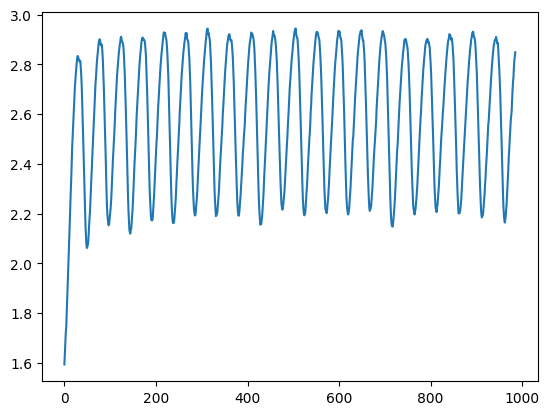

In [263]:
sns.lineplot(reference_feature.get(feature_name))

## 4. Inference

In [264]:
def save_video(image_list, output_path, fps=30):
    height, width = image_list[0].shape[:2]
    size = (width, height)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, size)

    for image in image_list:
        out.write(image.astype('uint8')) # bgr

    out.release()

In [265]:
inference_names = [fp.split('/')[-1].rstrip('.npy') for fp in glob(f'../data/sequence/{workout}/*.npy') if reference_name not in fp]
inference_names

['fr0s3SLFuco_05', 'DbOrOIEPwkQ_08', '-lNd79gryx8_06', '8kLckijkqTE_03']

In [273]:
inference_name = inference_names[2]
inference_sequence = np.load(f'../data/sequence/{workout}/{inference_name}.npy')

inference_name


'-lNd79gryx8_06'

In [274]:
counts, crosses = [], []
direction = 0 # 1 for up, -1 for down

inference_feature = FeatureExtractor()
mean, std = reference_feature.stat(feature_name)
for i, keypoints in enumerate(inference_sequence):
    keypoints = Keypoints(keypoints)
    inference_feature.update(keypoints, smoothen=True)

    feat = inference_feature.get(feature_name)[-1]
    zscore = (feat - mean) / std

    if abs(zscore) < 1:
        continue

    if direction == 0:
        direction = 1 if zscore < 0 else -1
    elif (zscore * direction) > 0:
        crosses.append(i)
        direction *= -1
        if len(crosses) % 2 != 0:
            counts.append(i)

print(len(counts))
print(counts)

6
[40, 115, 196, 279, 363, 449]


In [275]:
video_path = f'../data/workout/{workout}/{inference_name}.mp4'

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frames = []
count = 0
for i in range(num_frames):
    if i in counts:
        count += 1

    ret, frame = cap.read()
    if not ret:
        break

    cv2.putText(frame, f'count: {count}', (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    frames.append(frame)

save_path = video_path.replace('/workout/', '/result/')
os.makedirs(os.path.dirname(save_path), exist_ok=True)
save_video(frames, save_path)